# L3: Topic Models
### 732A92/TDDE16 Text Mining
Students: fanka300, milpo192

The purpose of this lab is to implement the standard Gibbs sampling algorithm for Latent Dirichlet Allocation in Python. You will be supplied starter code, a smaller corpus with State of the Union addresses for the period 1975 to 2000 by paragraph and a list with English stop words. The code is implemented as a class, `LDAGibbs`, where you are expected to replace central parts of the code with your own implementations.

### 1. Sampling

Implement the basic collapsed Gibbs sampling algorithm for Latent Dirichlet Allocation. Use the starter code and add the components that is missing (the sampler part). We use the fact that 

$$p(z_{i}=k)\propto\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\sum^{V}\left(\beta+n_{k,w_{i}}^{(w)}\right)}=\left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{V\beta+n_{k}}$$

to simplify computations, where $K$ is the number of topics, $V$ is the vocabulary size and $D$ is the number of documents. $\mathbf{n}^{(d)}$ is a count matrix of size $D\times K$ with the number of topic indicators by document, $d$, and topic $k$, $\mathbf{n}^{(w)}$ is a count matrix of size $K\times V$ with the number of topic indicators by topic, $k$, and word type, $w$. $\mathbf{n}$ is a topic indicator count vector of length $K$ that contain the number of topic indicators in each topic. The detailed algorithm can be found below:

__Data:__ tokenized corpus $\mathbf{w}$, priors $\alpha, \beta$ <br>
__Result:__ topic indicators $\mathbf{z}$

Init topic indicators $\mathbf{z}$ randomly per token<br>
Init topic probability vector $\mathbf{p}$<br>
Init $\mathbf{n}^{w}$, the topic type count matrix of size ($K \times V$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}^{d}$, the document topic count matrix of size ($D \times K$) with respect to $\mathbf{z}$<br>
Init $\mathbf{n}$, the topic count vector of length ($K$) with respect to $\mathbf{z}$<br>

for $g \leftarrow 1$ __to__ _num_\__iterations_ __do__<br>
&emsp;&emsp;// Iterate over all tokens<br>
&emsp;&emsp;for $i \leftarrow 1$ __to__ $N$ __do__<br>
&emsp;&emsp;&emsp;&emsp;// Remove current topic indicator $z_i$ from $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ -= 1, $n^{(d)}_{d_i,z_i}$ -= 1, $n_{z_i}$ -= 1<br>
&emsp;&emsp;&emsp;&emsp;for $k \leftarrow 1$ __to__ $K$ __do__<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;// Compute the unnormalized probability of each topic indicator<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$\mathbf{p}_k \leftarrow \left(\alpha+n_{d,k}^{(d)}\right)\frac{\left(\beta+n_{k,w_{i}}^{(w)}\right)}{\left(V\beta+n_{k}\right)}$<br>
&emsp;&emsp;&emsp;&emsp;__end__<br>
&emsp;&emsp;&emsp;&emsp;// Sample the topic indicator<br>
&emsp;&emsp;&emsp;&emsp;$z_i \leftarrow $ Categorical($\mathbf{p}$)<br>
&emsp;&emsp;&emsp;&emsp;// Add the new topic indicator $z_i$ to $\mathbf{n}^{w}$, $\mathbf{n}^{d}$ and $\mathbf{n}$<br>
&emsp;&emsp;&emsp;&emsp;$n^{(w)}_{z_i,w_i}$ += 1, $n^{(d)}_{d_i,z_i}$ += 1, $n_{z_i}$ += 1<br>
&emsp;&emsp;__end__<br>
__end__

For a complete derivation of the collapsed Gibbs sampler for LDA, see https://lingpipe.files.wordpress.com/2010/07/lda3.pdf.

In [2]:
import numpy, random, scipy.special
from tm3 import LDAGibbs
import matplotlib.pyplot as plt
random.seed(12345)

class MyGibbs(LDAGibbs):
        
    def __init__(self, num_topics, docs_file_name, stop_list_file_name = None):
        self.num_topics = num_topics
        self.num_docs = 0
        self.docs = []
        ## Prepare set of stop words
        self.stop_words = set()
        if stop_list_file_name != None:
            with open(stop_list_file_name) as f:
                for line in f:
                    word = line.rstrip()
                    self.stop_words.add(word)
        self.read_documents(docs_file_name)
        self.initialize_matrices()
        self.total_tokens = sum(self.doc_totals)
            
    def read_documents(self, filename):
        """Reads documents from a file, filters stop words and initializes
        the vocabulary. Also converts tokens to integer term IDs."""
        self.vocab = []
        self.vocab_ids = {}
        with open(filename) as f:
            for line in f:
                line = line.replace(".", " ").replace(",", " ").lower()
                self.num_docs += 1
                tokens = []
                for w in line.split():
                    if not w in self.stop_words:
                        if w in self.vocab_ids:
                            tokens.append(self.vocab_ids[w])
                        else:
                            term_id = len(self.vocab)
                            self.vocab.append(w)
                            self.vocab_ids[w] = term_id
                            tokens.append(term_id)
                self.docs.append({ 'tokens': tokens })
        self.num_terms = len(self.vocab)
        print("Read {} documents with a total of {} terms".format(self.num_docs, self.num_terms))
        
    def initialize_matrices(self):
        """Initializes numpy arrays for the matrix computations performed
        by the sampler during the MCMC process."""
        ## Set up numpy matrices
        self.term_topics = numpy.zeros((self.num_terms, self.num_topics)) # n^w
        self.doc_topics = numpy.zeros((self.num_docs, self.num_topics)) # n^d
        self.topic_totals = numpy.zeros(self.num_topics) # n
        self.doc_totals = numpy.zeros(self.num_docs)
        ## Initialize topics randomly
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            ## Create an array of random topic assignments
            doc['topics'] = [random.randrange(self.num_topics) for token in doc['tokens']]
            ## Construct the initial summary statistics
            doc_length = len(doc['tokens'])
            for token, topic in zip(doc['tokens'], doc['topics']):
                self.term_topics[token][topic] += 1 # n_wk
                self.doc_topics[doc_id][topic] += 1 # n_dk
                self.topic_totals[topic] += 1       # n_k
                self.doc_totals[doc_id] += 1
        ## Printout to check that everything is coherent
        #print(sum(sum(self.doc_topics)))
        #print(sum(sum(self.term_topics)))
        #print(sum(self.topic_totals))
        #print(sum(self.doc_totals))
        
    def run(self, num_iterations = 50, alpha = 0.1, beta = 0.01):
        self.num_iterations = num_iterations
        self.logprobs = []
        for iteration in range(num_iterations):
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs.append(logprob)
            print("iteration {}, {}".format(iteration, logprob))
            
    def make_draw(self, alpha, beta):
        ## TODO: implement this function for exercise 1
        V = len(self.vocab)
        for doc_id in range(self.num_docs):
            doc = self.docs[doc_id]
            #Some docs are empty:
            if not doc['tokens'] or not doc['topics']:
                continue     
            prob_k = numpy.zeros(self.num_topics)
            for j, (token, topic) in enumerate(zip(doc['tokens'], doc['topics'])):
                self.term_topics[token][topic] -= 1 # n_wk
                self.doc_topics[doc_id][topic] -= 1 # n_dk
                self.topic_totals[topic]-= 1       # n_k
                for topic2 in range(self.num_topics):
                    ndk = max(0,self.doc_topics[doc_id][topic2])
                    nkw = max(0,self.term_topics[token][topic2])
                    nk = max(0,self.topic_totals[topic2])
                    prob_k[topic2] = (alpha + ndk)*(beta + nkw)/(V*beta + nk)           
                num = int(self.num_topics) 
                num = range(num)
                prob_k = prob_k / sum(prob_k)
                z = int(numpy.random.choice(a=num,size=1,p=prob_k))
                self.term_topics[token][z] += 1 # n_wk
                self.doc_topics[doc_id][z] += 1 # n_dk
                self.topic_totals[z] += 1  
                doc['topics'][j] = z
                self.docs[doc_id] = doc
        #return super().make_draw(alpha, beta)
             
    def print_topics(self, j):
        ## TODO: implement this function for exercise 2
        for topic in range(self.num_topics):
            rows = self.term_topics[:,topic]
            rows_sort = numpy.sort(rows)[::-1]
            rows_ind = numpy.argsort(rows)[::-1]
            mylist = []
            for i in range(j):
                mylist.append((self.vocab[rows_ind[i]],rows_sort[i]))
            print(mylist)
    
    def plot(self):
        ## TODO: implement this function for exercise 3
        diff = 1
        self.logprobs2 = [0,]
        alpha = 0.1
        beta = 0.01
        while diff > 0.00001:
            self.make_draw(alpha, beta)
            logprob = self.compute_logprob(alpha, beta)
            self.logprobs2.append(logprob)
            diff = abs(self.logprobs2[-1] - self.logprobs2[-2])
        y=self.logprobs2[1:]
        x=range(len(y))
        print("Total iterations", len(y))
        plt.plot(x,y)
        #super().plot()            
    
    def compute_logprob(self, alpha, beta):
        ## TODO: implement this function for the bonus exercise
        return super().compute_logprob(alpha, beta)

Implement the `make_draw` function above. You should get behavior very similar to the results from calling the parent class.

In [3]:
num_topics = 10
num_iterations = 10

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.run(num_iterations)

Read 2898 documents with a total of 8695 terms
iteration 0, -10.369938318862618
iteration 1, -9.831967752279372
iteration 2, -9.561700400554749
iteration 3, -9.40005059306579
iteration 4, -9.27660953310218
iteration 5, -9.182245957778287
iteration 6, -9.108100217970685
iteration 7, -9.044728749052085
iteration 8, -8.994064564704564
iteration 9, -8.946403444326654


### 2. Top terms
Implement the `print_topics` function to extract the top `j` largest counts in $n(w)$ by row. This is the most probable word types in each topic.

In [4]:
model.print_topics(10)

[('congress', 146.0), ('year', 110.0), ('government', 95.0), ('president', 65.0), ('programs', 64.0), ('federal', 57.0), ('mr', 57.0), ('energy', 48.0), ('house', 48.0), ('members', 48.0)]
[('world', 219.0), ('soviet', 122.0), ('states', 119.0), ('united', 111.0), ('nuclear', 106.0), ('peace', 103.0), ('union', 81.0), ('nations', 81.0), ('war', 79.0), ('international', 73.0)]
[('federal', 171.0), ('government', 98.0), ('budget', 93.0), ('years', 90.0), ('percent', 88.0), ('tax', 87.0), ('billion', 81.0), ('year', 76.0), ('spending', 75.0), ('national', 71.0)]
[('people', 135.0), ('america', 132.0), ('freedom', 70.0), ('american', 61.0), ('world', 59.0), ('country', 54.0), ('congress', 53.0), ('americans', 52.0), ('opportunity', 50.0), ('years', 49.0)]
[('years', 113.0), ('government', 103.0), ('health', 88.0), ('care', 86.0), ('make', 80.0), ('budget', 77.0), ('tax', 72.0), ('american', 67.0), ('system', 66.0), ('people', 63.0)]
[('trade', 102.0), ('world', 93.0), ('free', 68.0), ('str

### 3. Explore the data

Run your implemention on the State of the Union corpus until convergence with 10 topics, don't forget to remove stop words. Plot the log marginal posterior by the number of iterations. How many iterations do you need until convergence? How do you interpret the topics?

[Hint: You can use the plot-function to print the marginal probability for each iteration. To get it working in Jupyter you need to run the command `%matplotlib inline` before plotting the first time.]

Read 2898 documents with a total of 8695 terms
Total iterations 505


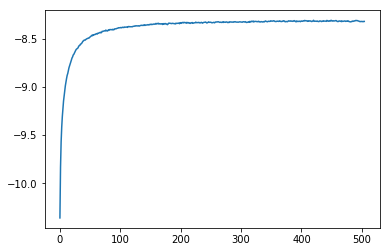

In [5]:
%matplotlib inline
num_topics = 10
#num_iterations = 5

model = MyGibbs(num_topics, 'sotu_1975_2000.txt', 'stoplist_en.txt')
model.plot()

In [6]:
model.print_topics(10)

[('budget', 219.0), ('year', 195.0), ('years', 185.0), ('tax', 158.0), ('percent', 152.0), ('billion', 139.0), ('spending', 135.0), ('federal', 134.0), ('million', 118.0), ('cut', 102.0)]
[('federal', 163.0), ('congress', 154.0), ('government', 136.0), ('programs', 104.0), ('states', 83.0), ('legislation', 80.0), ('administration', 73.0), ('local', 58.0), ('state', 57.0), ('rights', 57.0)]
[('children', 181.0), ('education', 100.0), ('schools', 96.0), ('school', 87.0), ('crime', 72.0), ('year', 64.0), ('parents', 59.0), ('college', 58.0), ('make', 56.0), ('space', 52.0)]
[('america', 235.0), ('world', 158.0), ('people', 134.0), ('years', 124.0), ('tonight', 119.0), ('american', 112.0), ('today', 101.0), ('century', 100.0), ('time', 94.0), ('union', 94.0)]
[('jobs', 121.0), ('private', 94.0), ('people', 87.0), ('economic', 83.0), ('government', 75.0), ('economy', 73.0), ('business', 70.0), ('american', 60.0), ('investment', 60.0), ('community', 59.0)]
[('trade', 116.0), ('economic', 90.

#### Answer here:

We chose a criterion for measuring the loglikelihood convergence to be the difference of loglikelihoods between consecutive iterations. More percisely, this difference should be below 0.00001. It took 505 iterations to reach it.

From the words that belong to each topic, we decided that topics could be:
1.  American federal budget
1.  American legislation
1.  Education
1.  Some historical perspective
1.  Jobs and business
1.  Foreign trade
1.  Cold war
1.  Energy and environment
1.  Future of America
1.  Healthcare

### 4. Simulate a new State of the Union speech

Write a function `new_speech` using the `MyGibbs` class to use the estimated values for $\Phi$ from your model (with stop words removed) to simulate a new State of the Union speech. Start out by simulating $\theta_d \sim Dir(\alpha = 0.5)$ and then simulate your document. Does it make sense? Why, why not?

In [7]:
def new_speech(model, alpha, num_words):
    speech = []
    theta_d = numpy.random.dirichlet(numpy.repeat(alpha, model.num_topics))
    for i in range(num_words):
        topic = numpy.random.choice(a=model.num_topics,size=1,p=theta_d)
        token_prob = model.term_topics[:,topic]
        prob = token_prob/sum(token_prob)
        prob = [val for sublist in prob for val in sublist]
        word = numpy.random.choice(a=len(model.vocab),size=1,p=prob)
        speech.append(model.vocab[int(word)])
    return " ".join(speech)

In [8]:
new_speech(model, 0.5, 100)

'jobs thing engineer years provided employment creating jobs back private star materials support sector save aid means engine invest build years carpenters sitting distressed ve tremendous private sector speech nation leaves represented job institutional neighborhoods quotas oil healthy ll branched trade airline sector investment trade end power approach seek future budget america sunrise restore world small hospital welfare markets save traders treatment businesses competitive end ve prevail disadvantaged workers cold choose future century seek developing removed works american closed monuments stepped created talented supply vital equitable congestion audit declined tax technological assumptions million spur ladder day business temporary expanded prices'

#### Answer here:

The speech does not make sense because we do not have stopwords and it is difficult to make a reasonable text without them. We also don't use any information about what the previous word(s) or topic were. Hence, the context is not taken into consideration when generating the speech. 

### Bonus assignment:

To get better understanding how to implement the underlying model or similar models, you might want to implement your own function to compute the log marginal posterior. If so, implement the `compute_logprob` function.

$$\begin{align}
\log p(\mathbf{z}|\mathbf{w}) =& \log\prod^{K}p(\mathbf{w}|\mathbf{z},\beta)\prod^{D}p(\mathbf{z}|\alpha) \\
=& \sum^{K}\log\left[\frac{\Gamma\left(\sum^{V}\beta\right)}{\prod^{V}\Gamma\left(\beta\right)}\frac{\prod^{V}\Gamma\left(n_{kv}^{(w)}+\beta\right)}{\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)}\right]+\sum^{D}\log\left[\frac{\Gamma\left(\sum^{K}\alpha\right)}{\prod^{K}\Gamma\left(\alpha\right)}\frac{\prod^{K}\Gamma\left(n_{dk}^{(d)}+\alpha\right)}{\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)}\right] \\
=& K\log\Gamma\left(V\beta\right)-KV\log\Gamma\left(\beta\right)+\sum^{K}\sum^{V}\log\Gamma\left(n_{kv}^{(w)}+\beta\right)-\sum^{K}\log\Gamma(\sum^{V}n_{kv}^{(w)}+\beta)\\
&+ D\log\Gamma\left(K\alpha\right)-DK\log\Gamma\left(\alpha\right)+\sum^{D}\sum^{K}\log\Gamma\left(n_{dk}^{(d)}+\alpha\right)-\sum^{D}\log\Gamma(\sum^{K}n_{dk}^{(d)}+\alpha)
\end{align}$$

In Python, use `scipy.special.gammaln` for $\log\Gamma(x)$ (if you run into problems, you might try `math.lgamma` instead).